In [43]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(1, os.path.abspath('.'))


import matplotlib.pyplot as plt
from IPython.display import display
from models import model_input

import numpy as np
from PIL import Image
import tensorflow as tf






def show_img(img, cmap=None, interpolation=None):
    fig = plt.figure()
    plt.imshow(img, cmap=cmap)
    display(fig)
    plt.close()
    
def print_stats(img, show=True, cmap=None, interpolation=None):
    print("Shape:\t", img.shape)
    print("Type: \t", img.dtype)
    if show:
        show_img(img, cmap, interpolation)
        
tfrecords_filename = '../data/processed/kitti/test.tfrecords'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


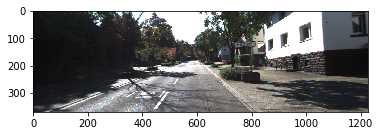

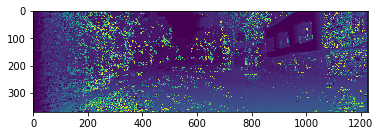

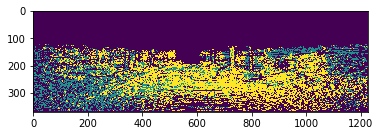

In [44]:
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)


reconstructed_images = []
for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    left_raw = (example.features.feature['left_raw']
                                .bytes_list
                                .value[0])
    
    disp_raw = (example.features.feature['disp_raw']
                                .bytes_list
                                .value[0])
    
    conf_raw = (example.features.feature['conf_raw']
                                .bytes_list
                                .value[0])
    
    left_reconstructed = np.fromstring(left_raw, dtype=np.uint8).reshape((height, width, -1))
    disp_reconstructed = np.fromstring(disp_raw, dtype=np.uint8).reshape((height, width))
    conf_reconstructed = np.fromstring(conf_raw, dtype=np.float32).reshape((height, width))

    reconstructed_images.append((left_reconstructed, disp_reconstructed, conf_reconstructed))
    
plt.imshow(reconstructed_images[0][0])
plt.figure()
plt.imshow(reconstructed_images[0][1])
plt.figure()
plt.imshow(reconstructed_images[0][2])

Filling queue with 100 CIFAR images before starting to train. This will take a few minutes.
(224, 224, 3)
(224, 224, 1)
(224, 224, 1)
current batch


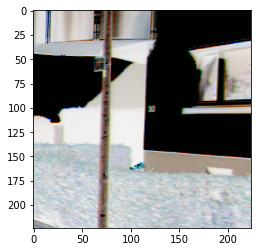

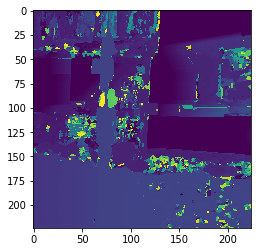

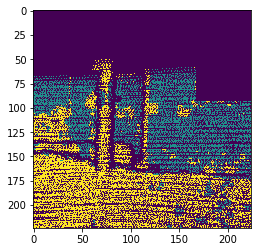

In [45]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=1)


left, disp, conf = model_input.distorted_inputs('kitti', batch_size=2)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/train',
                                      sess.graph)
    test_writer = tf.summary.FileWriter('../models/test')
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(1):
    
        l,d,g = sess.run([left,disp,conf])
        print(l[0, :, :, :].shape)
        print(d[0, :, :, :].shape)
        print(g[0, :, :, :].shape)
        
        print('current batch')
        
        
        plt.imshow(l[0, :, :, :])
        plt.figure()
        plt.imshow(np.squeeze(d[0, :, :, :]))
        plt.figure()
        plt.imshow(np.squeeze(g[0, :, :, :])) 
        plt.figure()
    
    coord.request_stop()
    coord.join(threads)

Filling queue with 100 CIFAR images before starting to train. This will take a few minutes.
Batch size:  2
(224, 224, 1)
(224, 224, 3)
(224, 224, 1)
(224, 224, 1)
current batch
(224, 224, 1)
(224, 224, 3)
(224, 224, 1)
(224, 224, 1)
current batch
(224, 224, 1)
(224, 224, 3)
(224, 224, 1)
(224, 224, 1)
current batch


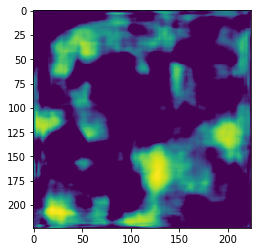

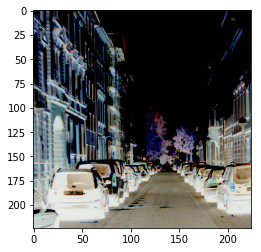

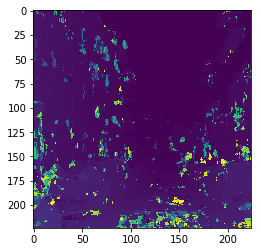

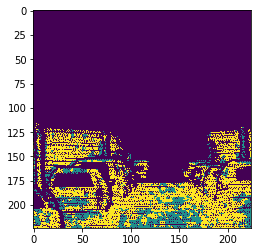

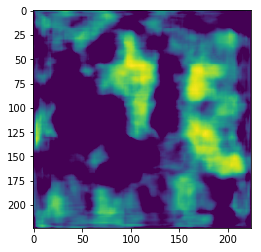

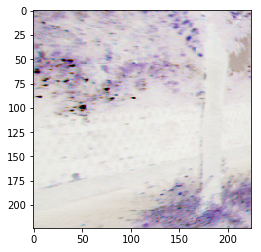

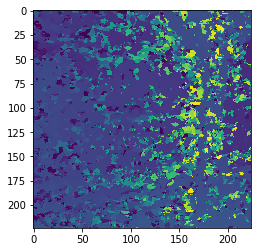

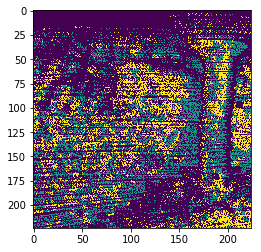

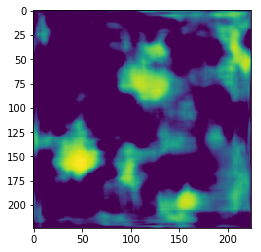

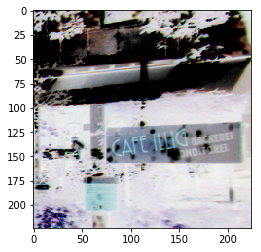

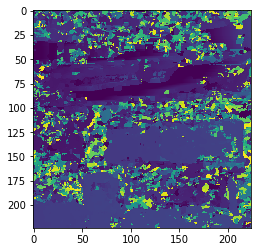

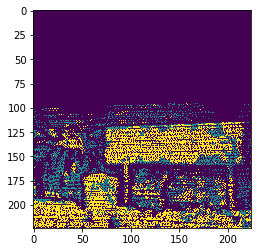

In [46]:
from models import model
tf.reset_default_graph()


left, disp, conf = model_input.distorted_inputs('kitti', batch_size=2)
output = model.inference(left, disp)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/train',
                                      sess.graph)
    test_writer = tf.summary.FileWriter('../models/test')
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
    
        p,l,d,g = sess.run([output,left,disp,conf])
        print(p[0, :, :, :].shape)
        print(l[0, :, :, :].shape)
        print(d[0, :, :, :].shape)
        print(g[0, :, :, :].shape)
        
        print('current batch')
        
        plt.imshow(np.squeeze(p[0, :, :, :]))
        plt.figure()
        plt.imshow(l[0, :, :, :])
        plt.figure()
        plt.imshow(np.squeeze(d[0, :, :, :]))
        plt.figure()
        plt.imshow(np.squeeze(g[0, :, :, :])) 
        plt.figure()
    
    coord.request_stop()
    coord.join(threads)